## ✨ Проект аналитики данных с использованием 
### HDFS, Spark и Hive в Jupyter Notebook  ✨ 
### Шаги реализации

1. Установка компонентов (Spark, Hive, Hadoop, Jupyter)
1. Создание структуры проекта
1. Чтение данных из HDFS с помощью Spark
1. Обработка данных (группировка, агрегация)
1. Сохранение результатов в HDFS
1. Интеграция с Hive
1. Визуализация результатов

#### Подключение к HDFS

In [1]:
from pyspark.sql import SparkSession
import os

# Инициализация SparkSession
spark = SparkSession.builder \
    .appName("HDFS_Spark_Hive_Analytics") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()
# Проверка подключения к HDFS
os.system("hdfs dfs -ls /data")

32512

### Чтение и запись данных с использованием Spark


In [2]:
# Чтение данных из HDFS
df = spark.read.csv("hdfs://namenode:9000/data/input_data.csv", header=True, inferSchema=True)
# Показать данные
df.show()
# Применение трансформаций (например, группировка и агрегация)
result_df = df.groupBy("category").agg({"value": "sum"})
result_df.show()
# Запись результата обратно в HDFS
result_df.write.csv("hdfs://namenode:9000/data/output_data.csv", header=True, mode="overwrite")

+--------+-----+
|category|value|
+--------+-----+
|       A|   50|
|       B|   75|
|       A|   25|
|       C|  100|
|       B|   60|
|       C|   40|
|       C|   80|
|       A|   55|
|       B|   95|
|       D|   10|
+--------+-----+

+--------+----------+
|category|sum(value)|
+--------+----------+
|       B|       230|
|       D|        10|
|       C|       220|
|       A|       130|
+--------+----------+



### Теперь мы можем интегрироваться с Hive и выполнять SQL-запросы:

In [3]:
# Создание таблицы в Hive
spark.sql("""
CREATE TABLE IF NOT EXISTS analytics_data (
    category STRING,
    value FLOAT
) USING hive
""")
# Заполнение таблицы данными из DataFrame
result_df.createOrReplaceTempView("temp_data")
spark.sql("INSERT INTO TABLE analytics_data SELECT * FROM temp_data")
# Выполнение SQL-запроса к таблице Hive
hive_results = spark.sql("SELECT * FROM analytics_data WHERE value > 100")
hive_results.show()

+--------+-----+
|category|value|
+--------+-----+
|       B|230.0|
|       C|220.0|
|       A|130.0|
+--------+-----+



### Анализ и визуализация данных

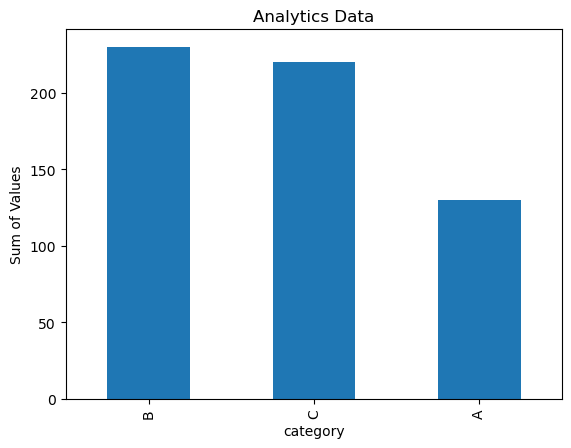

In [4]:
import matplotlib.pyplot as plt
# Преобразуем результаты в Pandas DataFrame для визуализации
pdf = hive_results.toPandas()

# Визуализация данных
pdf.plot(kind='bar', x='category', y='value', title='Analytics Data', legend=False)
plt.ylabel('Sum of Values')
plt.show()

### Вычислим долю каждой категории в общем объёме (value) и визуализируем её как круговую диаграмму (pie chart) 

In [6]:
hive_results_pd = hive_results.toPandas()

total_value = hive_results_pd["value"].sum()
hive_results_pd["percent"] = (hive_results_pd["value"] / total_value) * 100
hive_results_pd["percent"] = hive_results_pd["percent"].round(2)
hive_results_pd[["category", "value", "percent"]]


,category,value,percent
0,B,230.0,39.66
1,C,220.0,37.93
2,A,130.0,22.41


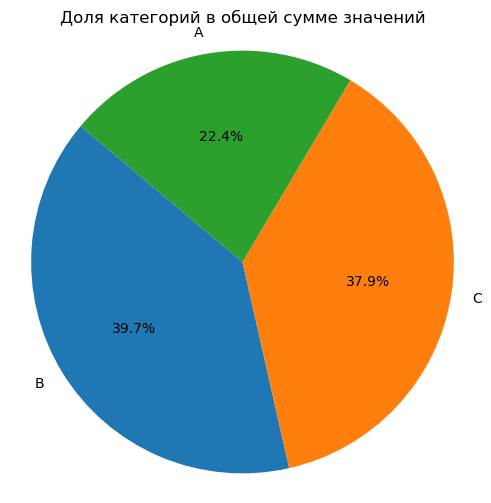

In [7]:
plt.figure(figsize=(6,6))
plt.pie(
    hive_results_pd["value"],
    labels=hive_results_pd["category"],
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Доля категорий в общей сумме значений")
plt.axis('equal')
plt.show()